# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

### Programmmer : Kaung Myat Tun 
### Project              : Image Classifier Project

In [9]:
# Import Pytorch Packages

import torch  
from torch import nn,optim
from torchvision import datasets,models,transforms
from PIL import Image



In [10]:
# Import Numpy and Matplotlib pacakges

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format ="retina"

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [11]:
# Directory of Image Data 
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [12]:
# transforms for the training, validation, and testing sets
data_transforms = transforms.Compose( [ transforms.Resize(255),
                                        transforms.CenterCrop(224), 
                                        transforms.ToTensor(),
                                        transforms.Normalize( (0.485, 0.456, 0.406),(0.229, 0.224, 0.225) ) ] )


## transforms for the training set using Data Argumentation 
train_transforms = transforms.Compose( [ transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize( (0.485, 0.456, 0.406),(0.229, 0.224, 0.225) ) ] )

## transforms for validation set
valid_transforms = data_transforms

## transforms for testing set
test_transforms = data_transforms



In [13]:
# Load the Datasets with ImageFolder 
image_datasets =datasets.ImageFolder(data_dir,transform=data_transforms)

# Load training Dataset
train_datasets =datasets.ImageFolder(train_dir,transform=train_transforms)

# Load validation Dataset
valid_datasets =datasets.ImageFolder(valid_dir,transform=valid_transforms)

# Load test Dataset
test_datasets =datasets.ImageFolder(test_dir,transform=test_transforms)

In [14]:
# Dataloader and batch size 
dataloaders =torch.utils.data.DataLoader(image_datasets,batch_size=64,shuffle=True)

#Trainloader
trainloaders =torch.utils.data.DataLoader(train_datasets,batch_size=64,shuffle=True)

#Validloader
validloaders =torch.utils.data.DataLoader(valid_datasets,batch_size=64,shuffle=True)

#Testloader
testloaders =torch.utils.data.DataLoader(test_datasets,batch_size=64,shuffle=True)


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [15]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [16]:
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [17]:
# TODO: Build and train your network

# Use GPU if avaliable 
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
print(type(device))

<class 'torch.Device'>


In [19]:
# Use Pretrained VGG model 
model =models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 101196479.38it/s]


In [21]:
# Check Model 
model 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [22]:
#Frozen the parameters 
#They can't  get Updated during Training 
#Turning off gradient 
for param in model.parameters():
    param.requires_grad=False

In [23]:
# Define our new Classifier using only 1 hidden Layer
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict ( [ 
                            ('fc1'   ,   nn.Linear(25088,4096) ),
                            ('relu'  ,   nn.ReLU()             ),
                            ('dou'   ,   nn.Dropout(p=0.2)     ),
                            ('fc2'   ,   nn.Linear(4096,102)   ),
                            ('output',  nn.LogSoftmax(dim=1)   ) ] ) )

In [24]:
## Update Classifier and check model again 
model.classifier=classifier
model 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [25]:
# define loss Since we use logsoftmax as output we use  negative log likelihood loss

criterion = nn.NLLLoss()

# define optimizer to update the weights with gradients

optimizer = optim.Adam(model.classifier.parameters(),lr=0.002)

In [26]:
def train_test(mode=0,model=None,criterion=None,optimizer=None,loader=None,device='cpu') :
    
    accuracy=0
    running_loss=0
    # Check GPU avilable if available move model to GPU
    if torch.cuda.is_available() :
        model.cuda()
        print("GPU mode")
    else :
        model.cpu()
        print("CPU mode")
        
    #Check mode to dropout
    if mode == 0 :
        model.train()
    else :
        model.eval()
        
    for images,labels in loader :
        
        # Run model on gpu if available
        images,labels=images.to(device),labels.to(device)
        
        #clear gradients 
        optimizer.zero_grad()
        
        #forward pass
        output=model.forward(images)
        
        #calculate Loss
        loss=criterion(output,labels)
        
        #if training mode else skip backward propogation
        if mode == 0 :
        
            #Backward Propogation
            loss.backward()
        
            #Update Weight 
            optimizer.step()
        
        #Keep track loss 
        running_loss +=loss.item()
        
        #Calculate Accuracy
        if mode == 0:
            accuracy=0
            
        else: 
            ps=torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    return (running_loss/len(loader)),(accuracy/len(loader))
        

In [27]:
epochs= 5

for epoch in range(epochs):
    
    # Train model
    train_loss,train_accuracy = train_test(0,model,criterion,optimizer,trainloaders,device)
    
    # Validate model 
    with torch.no_grad():
        valid_loss,valid_accuracy = train_test(1,model,criterion,optimizer,validloaders,device)
        
    # print description 
    print("Epoch  :{}/{} \n ".format(epoch+1,epochs))
    print("Traning Loss :{} \n ".format(train_loss))
    print("Validation Loss :{} \n ".format(valid_loss))
    print("Validation Accuracy :{} \n ".format(valid_accuracy))



GPU mode
GPU mode
Epoch  :1/5 
 
Traning Loss :4.5005537526121415 
 
Validation Loss :1.0705443345583403 
 
Validation Accuracy :0.7038942300356351 
 
GPU mode
GPU mode
Epoch  :2/5 
 
Traning Loss :1.486563720170734 
 
Validation Loss :0.7159533202648163 
 
Validation Accuracy :0.8048557684971736 
 
GPU mode
GPU mode
Epoch  :3/5 
 
Traning Loss :1.3472939521363638 
 
Validation Loss :0.6624969106454116 
 
Validation Accuracy :0.8144711531125582 
 
GPU mode
GPU mode
Epoch  :4/5 
 
Traning Loss :1.1444717587776554 
 
Validation Loss :0.6642318711831019 
 
Validation Accuracy :0.8137500011003934 
 
GPU mode
GPU mode
Epoch  :5/5 
 
Traning Loss :1.1675838336203863 
 
Validation Loss :0.623082195337002 
 
Validation Accuracy :0.8372596135506263 
 


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [28]:
# validation on the test set
with torch.no_grad():
        test_loss,test_accuracy = train_test(1,model,criterion,optimizer,testloaders,device)

print("Testing Loss :{} \n ".format(test_loss))
print("Testing Accuracy :{} \n ".format(test_accuracy*100))


GPU mode
Testing Loss :0.6829714201963865 
 
Testing Accuracy :83.2885558788593 
 


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [29]:
model.class_to_idx = train_datasets.class_to_idx
print(model.class_to_idx)

{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

In [30]:
model.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.fc1.weight', 'classifier.fc1.bias', 'classifier.fc2.weight', 'classifier.fc2.bias'])

In [31]:
optimizer.state_dict().keys()

dict_keys(['state', 'param_groups'])

In [34]:
#Create Checkpoint 
checkpoint = {  'arch '           : 'vgg16',
                'model'           : model,
                'input_size'      : 25088,
                'output_size'     : 102,
                'opti_state_dict' : optimizer.state_dict(),
                'learning_rate'   :0.02,
                'state_dict'      : model.state_dict(),
                'classifier'      : model.classifier,
                'epochs'          : 5,
                'class_to_idx'    : model.class_to_idx
             }

In [35]:
#Save Checkpoint 
torch.save(checkpoint,'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [36]:
#function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath) :
    checkpoint = torch.load(filepath)
    model=checkpoint["model"]
    model.classifier=checkpoint["classifier"]
    model.load_state_dict(checkpoint['state_dict'])
    optimizer = optim.Adam(model.classifier.parameters(),checkpoint['learning_rate'])
    optimizer.load_state_dict(checkpoint['opti_state_dict'])
    epochs = checkpoint['epochs']
    model.class_to_idx=checkpoint['class_to_idx']
    
    return model
    

In [37]:
model=load_checkpoint('checkpoint.pth')
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [38]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
   # Open image file 
    img=Image.open(image)
    
    # find the shorter size and set to 256 pixels
    width,height=img.size

    if width > height :
        img=img.resize((width,256)) 
    else :
        img =img.resize((256,height))
        
   #Crop the image as 224 x 224
    width,height=img.size    
    left =(width -224)/2
    upper=(height -224)/2
    right =(width +224)/2
    lower=(height +224)/2
    img=img.crop((left,upper,right,lower))
    
    #Changing pillow image to np array
    img=np.array(img)
    img=img/[255,255,255]
    
    #Normalize the image 
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    img=(img - mean)/std
    
    #To match with pytorch 
    img = np.transpose(img,(2,0,1))
    
    return img 
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [39]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [40]:
#Choose random image
import os, random
randir=test_dir+"/7/"
image=random.choice(os.listdir(randir))
image_path =randir+image
print(image_path)

flowers/test/7/image_07218.jpg


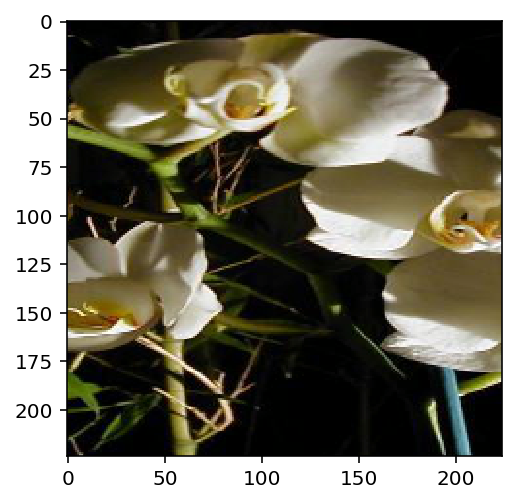

In [41]:
# test processed picture
imshow(process_image(image_path))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [42]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    mapped_lst=[]
    # Check GPU avilable if available move model to GPU
    if torch.cuda.is_available() :
        model.cuda()
        print("GPU mode")
    else :
        model.cpu()
        print("CPU mode")
        
        
    # predict image (like testing data set)
    with torch.no_grad():
        model.eval()
        img=process_image(image_path) # rreturn numpy array but match with torch
        img=torch.from_numpy(img).unsqueeze(0).to(device)
        
        output=model.forward(img.float())
        ps=torch.exp(output)
        top_p, top_class = ps.topk(topk)
        
        # change back to cpu and numpy
        top_p=top_p.detach().cpu().numpy().tolist()[0]
        top_class=top_class.detach().cpu().numpy().tolist()[0]
        
        # invert dictionary 
        idx_to_class ={value : key for (key, value) in model.class_to_idx.items()}
        
        #find the class in class to idx and mapped it
        for item in top_class :
            mapped_lst.append(idx_to_class[item])
            
        return top_p,mapped_lst
        

GPU mode
[0.3722451627254486, 0.32587265968322754, 0.16144676506519318, 0.07106539607048035, 0.03296210616827011, 0.028622834011912346, 0.003293059766292572, 0.002424670848995447]
['87', '73', '20', '78', '88', '7', '49', '81']
['magnolia', 'water lily', 'giant white arum lily', 'lotus lotus', 'cyclamen', 'moon orchid', 'oxeye daisy', 'frangipani']


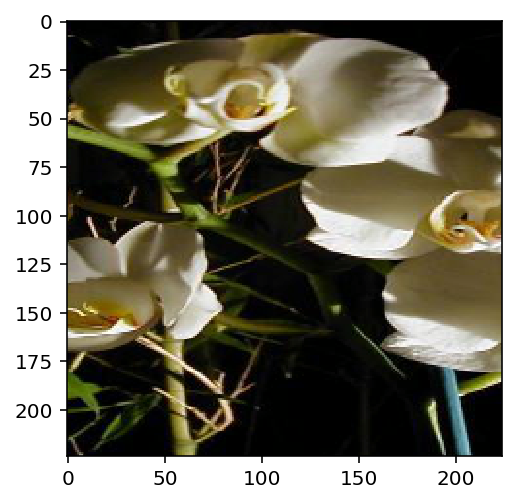

In [43]:
# test predict
imshow(process_image(image_path))
prob,classes=predict(image_path, model,8)
print(prob)
print(classes)
print([cat_to_name[item] for item in classes])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [44]:
def display_top_5 (image_path,model) :
    
    #Open Image 
    img=Image.open(image_path)
    
    #Predict Image
    probs,classes=predict(image_path,model)
    
    # find and mapped with top 5 label
    all_classes =[cat_to_name[item] for item in classes]
    #print(max(all_classes))
    #print(max(int(all_classes)))
    
    #Use matplot to illustrate
    fig,ax=plt.subplots(2,1)
    
    #For First part
    ax[0].imshow(img);
    ax[0].set_title(all_classes[np.argmax(probs)])
    ax[0].axis('off')
    
    #For Second Part
    y_post=np.arange(len(all_classes))
    ax[1].set_yticks(y_post)
    ax[1].set_yticklabels(all_classes)
    ax[1].invert_yaxis()
    ax[1].barh(y_post,probs,align="center")
    
    
    
    
    
    



GPU mode


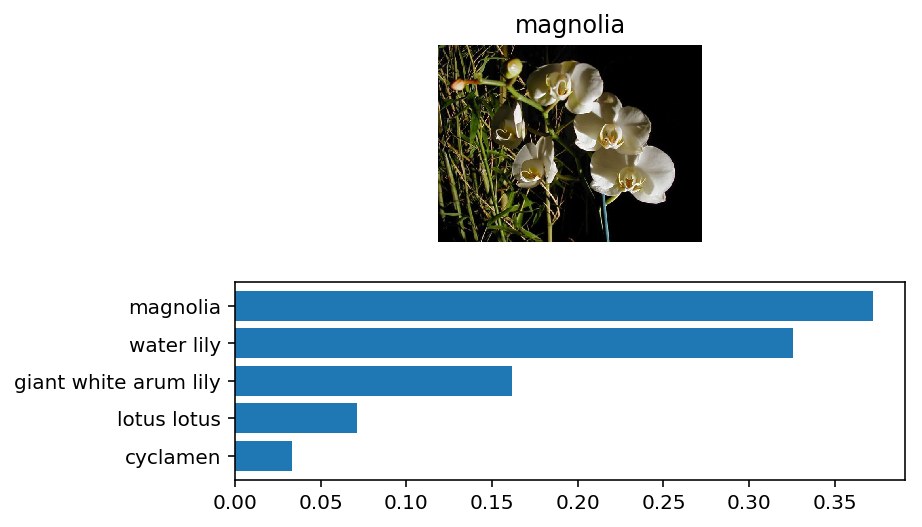

In [45]:
display_top_5(image_path, model)